## `xgboost` weighted multi target

In [1]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [23]:
def make_custom_obj(weight_matrix):
    """
    Custom objective with individual weight for each Y element.
    
    Args:
        weight_matrix: array of shape (n, k) - weight for each Y[i, j]
    """
    # Flatten weight matrix in the same order as XGBoost
    # weights = weight_matrix.ravel()
    
    def objective(y_true, y_pred):
        grad =  weight_matrix*(y_pred - y_true.reshape(y_pred.shape))
        hess =  weight_matrix*np.ones_like(y_pred)
        
        return grad, hess

    return objective

## Example with Barra returns

In [24]:
# Generate sample data
np.random.seed(42)
n, p, k = 1000, 10, 2  # n samples, p features, k targets

# Create feature matrix X (n x p)
X = np.random.randn(n, p)
R = np.ones((p,k))
R[:,1]=-1
e = np.random.randn(n, k)

Y = X @ R + e

W = np.ones_like(Y)
W[int(n/2):,0]=0
W[:int(n/2),1]=0

model = XGBRegressor(
    n_estimators=10,
    learning_rate=0.1,
    tree_method="hist",
    multi_strategy="multi_output_tree",
    random_state=42,
    objective=make_custom_obj(W)
)
model.fit(X, Y)

Y_hat = model.predict(X)

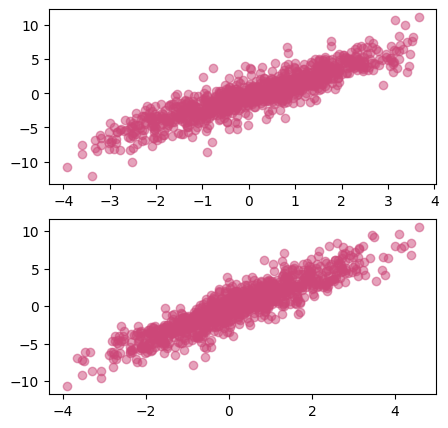

In [25]:
cmap = cm.plasma
fig, ax =plt.subplots(2,1,figsize=(5,5))
for i in range(k):
    ax[i].plot(Y_hat[:,i], Y[:,i], "o", alpha=0.5, color=cmap(0.5))